In [15]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
from skimage.draw import ellipse
import random

from sklearn.model_selection import train_test_split

import pickle
import torch

from torch import nn

from typing import List

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import os

from torch.utils.tensorboard import SummaryWriter

In [16]:
debug = True
do_train = False

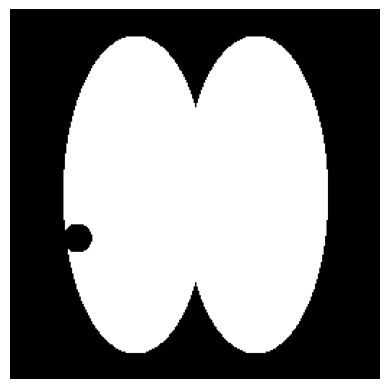

In [17]:
# Create a blank white image
if debug:
    width, height = 256, 256
    image = np.zeros((height, width), dtype=np.uint8)

    x = 110
    y = 50
    d = y / 1.2 # 1.1 - 1.2

    # Define the center and axes for the ellipse
    center1 = (256 / 2, 256 / 2 + d)  # (row, col)
    center2 = (256 / 2, 256 / 2 - d)  # (row, col)
    axis_lengths = (x, y)  # (vertical axis, horizontal axis) 90-110, 50-70

    # Draw the ellipse
    rr, cc = ellipse(center1[0], center1[1], axis_lengths[0], axis_lengths[1], shape=image.shape)
    image[rr, cc] = 255  # Black color for the ellipse
    rr, cc = ellipse(center2[0], center2[1], axis_lengths[0], axis_lengths[1], shape=image.shape)
    image[rr, cc] = 255  # Black color for the ellipse

    rr, cc = ellipse(center2[0] + 30, center2[1] - 40, 10, 10, shape=image.shape) # size - (10, 10) - (
    image[rr, cc] = 0  # Black color for the ellipse

    # Display the image using matplotlib
    plt.imshow(image, cmap='gray')
    plt.axis('off')  # Turn off axis for better visualization
    plt.show()

    # Optionally, save the image
    # plt.imsave('ellipse_skimage.png', image, cmap='gray')


In [18]:
def create_artificial_lung(min_r, max_r, min_c, max_c, width=256, height=256):
    img = np.zeros((height, width), dtype=np.uint8)
    r1 = random.randint(min_r, max_r)
    c1 = random.randint(min_c, max_c)
    y1, x1 = height / 2, width / 2
    rr, cc = ellipse(y1, x1, r1, c1, shape=img.shape)
    img[rr, cc] = 255
    return img

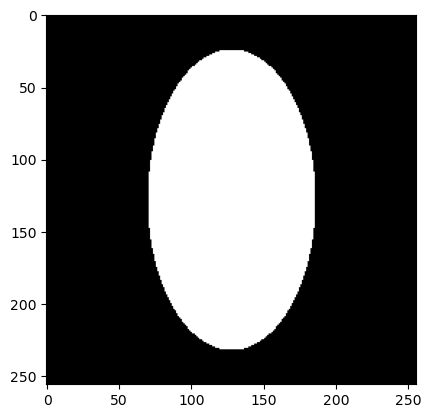

In [19]:
if debug:
    min_r = 90
    max_r = 110
    min_c = 50
    max_c = 70
    plt.imshow(create_artificial_lung(min_r, max_r, min_c, max_c))

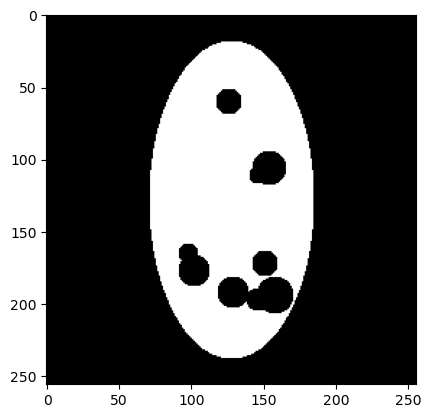

In [20]:
def make_holed_lung(img, min_num_of_holes, max_num_of_holes, min_size, max_size, min_dx, max_dx, min_dy, max_dy, width=256, height=256):
    new_img = img.copy()
    num_of_holes = random.randint(min_num_of_holes, max_num_of_holes)
    for _ in range(num_of_holes):
        size = random.randint(min_size, max_size)
        dx = random.randint(min_dx, max_dx)
        dy = random.randint(min_dy, max_dy)
        y = height / 2 - dy
        x = width / 2 - dx
        rr, cc = ellipse(y, x, size, size, shape=new_img.shape)
        new_img[rr, cc] = 0
    return new_img

if debug:
    example_img = create_artificial_lung(min_r, max_r, min_c, max_c)
    img = make_holed_lung(example_img, 1, 10, 5, 15, -60, 60, -80, 80)
    plt.gray()
    plt.imshow(img)
        

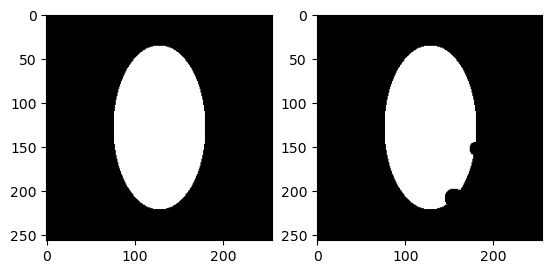

In [21]:
min_r = 90
max_r = 110
min_c = 50
max_c = 70
min_d_coeff = 1.1
max_d_coeff = 1.2
min_num_of_holes = 1
max_num_of_holes = 10
min_size = 5
max_size = 15
min_dx = -60
max_dx = 60
min_dy = -80
max_dy = 80

def create_sample():
    lung = create_artificial_lung(min_r, max_r, min_c, max_c)
    holed_lung = make_holed_lung(lung, min_num_of_holes, max_num_of_holes, min_size, max_size, min_dx, max_dx, min_dy, max_dy)
    return lung, holed_lung

if debug:
    lung, holed_lung = create_sample()

    fig, axes = plt.subplots(nrows=1, ncols=2)
    axes[0].imshow(lung)
    axes[1].imshow(holed_lung)
    

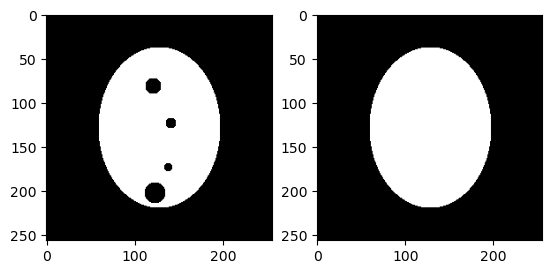

In [22]:
data_size = 12000

data = [create_sample() for _ in range(data_size)]
Y = [d[0] for d in data]
X = [d[1] for d in data]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

fix, axes = plt.subplots(nrows=1, ncols=2)

axes[0].imshow(X[0])
axes[1].imshow(Y[0])

In [23]:

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [24]:


class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(32, 1, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = Autoencoder().to(device)
if debug:
    print(model)

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
  )
  (decoder): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Upsample(scale_factor=2.0, mode='neares

In [25]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual  # Add skip connection
        out = self.relu(out)
        return out

class ResidualAutoencoder(nn.Module):
    def __init__(self):
        super(ResidualAutoencoder, self).__init__()
        
        # Encoder layers with residual blocks
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.enc_res1 = ResidualBlock(32)
        self.enc_pool1 = nn.MaxPool2d(2, 2)
        
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(32, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU()
        )
        self.enc_res2 = ResidualBlock(16)
        self.enc_pool2 = nn.MaxPool2d(2, 2)
        
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU()
        )
        self.enc_res3 = ResidualBlock(8)
        
        # Decoder layers with residual blocks and skip connections
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU()
        )
        self.dec_res1 = ResidualBlock(16)
        self.dec_up1 = nn.Upsample(scale_factor=2)
        
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.dec_res2 = ResidualBlock(32)
        self.dec_up2 = nn.Upsample(scale_factor=2)
        
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.dec_res3 = ResidualBlock(32)
        
        # Final output layer
        self.final_conv = nn.Sequential(
            nn.Conv2d(32, 1, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Encoder path with residual connections
        e1 = self.enc_conv1(x)
        e1 = self.enc_res1(e1)
        p1 = self.enc_pool1(e1)
        
        e2 = self.enc_conv2(p1)
        e2 = self.enc_res2(e2)
        p2 = self.enc_pool2(e2)
        
        e3 = self.enc_conv3(p2)
        e3 = self.enc_res3(e3)
        
        # Decoder path with residual connections and skip connections
        d1 = self.dec_conv1(e3)
        d1 = self.dec_res1(d1)
        u1 = self.dec_up1(d1)
        # Add skip connection from encoder
        u1 = u1 + e2
        
        d2 = self.dec_conv2(u1)
        d2 = self.dec_res2(d2)
        u2 = self.dec_up2(d2)
        # Add skip connection from encoder
        u2 = u2 + e1
        
        d3 = self.dec_conv3(u2)
        d3 = self.dec_res3(d3)
        
        # Final output
        out = self.final_conv(d3)
        
        return out

model = ResidualAutoencoder().to(device)
print(model)

ResidualAutoencoder(
  (enc_conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (enc_res1): ResidualBlock(
    (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (enc_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc_conv2): Sequential(
    (0): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (enc_res2): ResidualBlock(
    (conv1): Conv2d(16, 16, kernel_size=(3, 3),

In [26]:

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(256, scale=(0.8, 1.0)),
    transforms.RandomRotation(30),
    transforms.RandomAffine(degrees=0, translate=(0.3, 0.3))
])

class EllipsesDataset(Dataset):
    def __init__(self, noisy_data: List[np.array], data: List[np.array], transform=None):
        self.noisy_data = [torch.clamp(torch.tensor(nd, dtype=torch.float).unsqueeze(0), max=1.0) for nd in noisy_data]
        self.data = [torch.clamp(torch.tensor(d, dtype=torch.float).unsqueeze(0), max=1.0) for d in data]
        self.transform = transform

    def __len__(self):
        return len(self.noisy_data)

    def __getitem__(self, idx):
        if self.transform is not None:
            state = torch.get_rng_state()
            noisy_img = self.transform(self.noisy_data[idx])
            torch.set_rng_state(state)
            img = self.transform(self.data[idx])
            return noisy_img, img
        else:
            return self.noisy_data[idx], self.data[idx]


train_dataset = EllipsesDataset(X_train, Y_train, transform=train_transform)
test_dataset = EllipsesDataset(X_test, Y_test, transform=train_transform)


train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [27]:
import time

def train(model, train_loader, criterion, optimizer, save_dir, num_epochs=10, device='cuda'):
    losses = list()
    writer = SummaryWriter()
    for epoch in range(num_epochs):
        epoch_start = time.time()
        running_loss = 0.0
        for batch_idx, (noisy_data, data) in enumerate(train_loader):
            batch_time = time.time()
            noisy_data, data = noisy_data.to(device), data.to(device)
            # Zero the gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(noisy_data)
            loss = criterion(outputs, data)
            writer.add_scalar('Loss/train_batch', loss.item(), epoch * len(train_loader) + batch_idx)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            writer.add_scalar('Loss/runnning', running_loss, epoch * len(train_loader) + batch_idx)

            barch_end_time = time.time() - batch_time 
            writer.add_scalar('Time/train_batch', barch_end_time, epoch * len(train_loader) + batch_idx)

        epoch_end_time = time.time() - epoch_start 
        writer.add_scalar('Time/train_epoch', epoch_end_time, epoch) 
        epoch_loss = running_loss / len(train_loader)
        writer.add_scalar('Loss/train_epoch', epoch_loss, epoch)
        losses.append(epoch_loss)
        torch.save(model.state_dict(), os.path.join(save_dir, f'epoch_{epoch+1}.pth'))
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f} Time: {epoch_end_time:.2f}s')
    writer.close()
    return {
        "loss": losses
    }

In [28]:
if do_train:
    print("Training")
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters())
    history = train(model, train_loader, criterion, optimizer, "./model", num_epochs=50)
    with open("history.pkl", "wb") as f:
        pickle.dump(history, f)
else:
    print("Loading model")
    model.load_state_dict(torch.load("./model/epoch_1.pth"))

Loading model


/tmp/ipykernel_22029/936757357.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("./model/epoch_1.pth"))


In [29]:
noisy_data, data = next(iter(test_loader))

save_data_to_imgs = False

if save_data_to_imgs:
    for i in range(len(noisy_data)):
        i_str = str(i).zfill(2)
        noisy_img = noisy_data[i].squeeze().detach().cpu().numpy()
        img = data[i].squeeze().detach().cpu().numpy()
        # ./data/noisy
        plt.imsave(f"./data/noisy/{i_str}.png", noisy_img, cmap='gray')
        plt.imsave(f"./data/full/{i_str}.png", img, cmap='gray')



In [30]:
noisy_data, data = noisy_data.to(device), data.to(device)
print(noisy_data.shape, data.shape)

torch.Size([16, 1, 256, 256]) torch.Size([16, 1, 256, 256])


In [31]:
def dice_score(pred, target):
    smooth = 1e-6
    intersection = (pred * target).sum()
    return (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)
# Mean dice: 0.9849625215600671

In [32]:
def plot_and_dice(loaded_model, noisy_data, data):
    outputs = loaded_model(noisy_data) > 0.5
    dice_scores = list()
    fig, axes = plt.subplots(nrows=3, ncols=len(outputs), figsize=(20, 10))
    plt.subplots_adjust(bottom=0.3, top=0.7, hspace=0)
    for ax in axes.flatten():
        ax.axis('off')
        for i in range(len(outputs)):
            out = outputs[i].squeeze().detach().cpu().numpy()
            d = data[i].squeeze().detach().cpu().numpy()
            noisy = noisy_data[i].squeeze().detach().cpu().numpy()
            axes[0][i].imshow(out)
            axes[1][i].imshow(d)
            axes[1][i].set_title("Expected")
            axes[2][i].imshow(noisy)
            axes[2][i].set_title("Noisy")
            one_dice = dice_score(out, d)
            
            dice_scores.append(one_dice)
            axes[0][i].set_title(f"Dice: {one_dice:.2f}")

    plt.gray()
    plt.show()

    print(f"Mean dice: {np.mean(dice_scores)}")
    return np.mean(dice_scores)


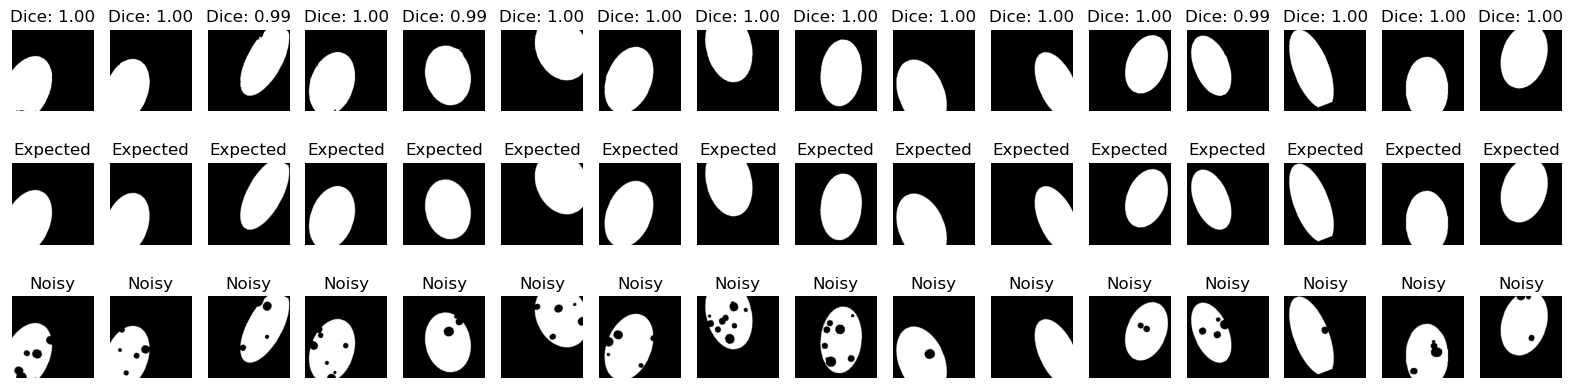

Mean dice: 0.9961400376885159


0.9961400376885159

In [33]:
plot_and_dice(model, noisy_data, data)

/tmp/ipykernel_22029/3623847153.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  old_model.load_state_dict(torch.load("./model/big_holes_old_epoch_30.pth"))


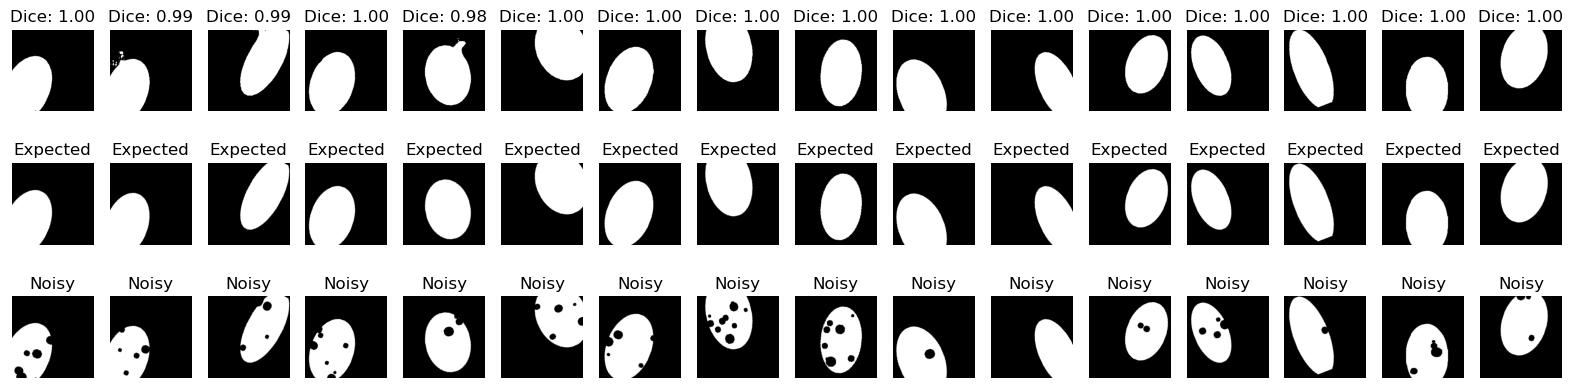

Mean dice: 0.9943489146593899


0.9943489146593899

In [35]:
old_model = ResidualAutoencoder().to(device)
old_model.load_state_dict(torch.load("./model/big_holes_old_epoch_30.pth"))
plot_and_dice(old_model, noisy_data, data)

# Test

['./data/noisy/eroded_0.bmp', './data/noisy/eroded_1.bmp', './data/noisy/eroded_10.bmp', './data/noisy/eroded_11.bmp', './data/noisy/eroded_12.bmp', './data/noisy/eroded_13.bmp', './data/noisy/eroded_14.bmp', './data/noisy/eroded_15.bmp', './data/noisy/eroded_16.bmp', './data/noisy/eroded_17.bmp', './data/noisy/eroded_18.bmp', './data/noisy/eroded_19.bmp', './data/noisy/eroded_2.bmp', './data/noisy/eroded_20.bmp', './data/noisy/eroded_21.bmp', './data/noisy/eroded_22.bmp', './data/noisy/eroded_23.bmp', './data/noisy/eroded_24.bmp', './data/noisy/eroded_25.bmp', './data/noisy/eroded_26.bmp', './data/noisy/eroded_27.bmp', './data/noisy/eroded_28.bmp', './data/noisy/eroded_29.bmp', './data/noisy/eroded_3.bmp', './data/noisy/eroded_30.bmp', './data/noisy/eroded_31.bmp', './data/noisy/eroded_32.bmp', './data/noisy/eroded_33.bmp', './data/noisy/eroded_34.bmp', './data/noisy/eroded_35.bmp', './data/noisy/eroded_36.bmp', './data/noisy/eroded_37.bmp', './data/noisy/eroded_38.bmp', './data/noisy

/tmp/ipykernel_22029/1508087918.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_name))


Tensor Shape: torch.Size([50, 1, 256, 256])
Batch 0


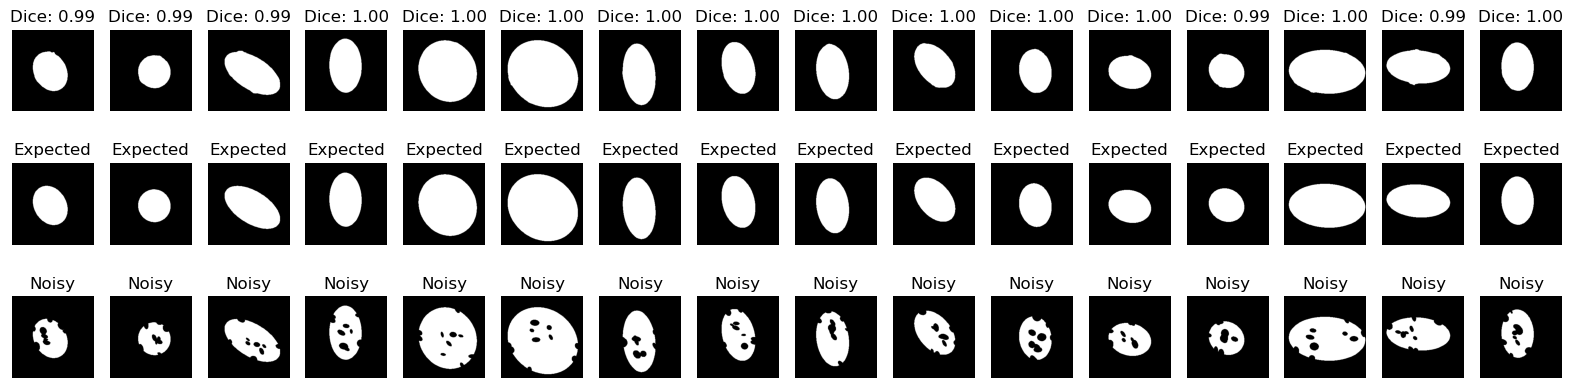

Mean dice: 0.9968262464116249
End of batch 0
Batch 1


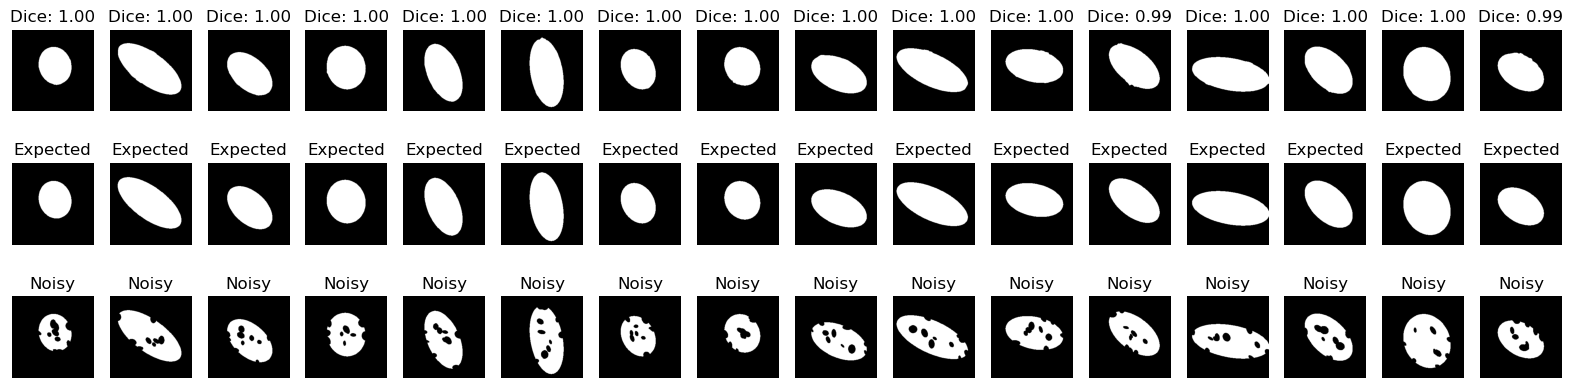

Mean dice: 0.9969886642879867
End of batch 1
Batch 2


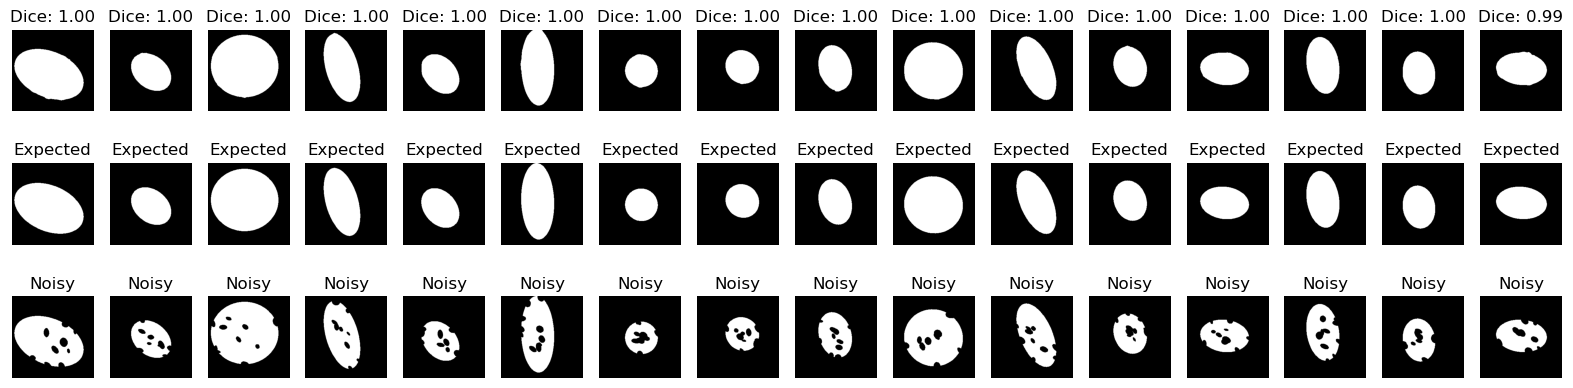

Mean dice: 0.9975663146547601
End of batch 2
Batch 3


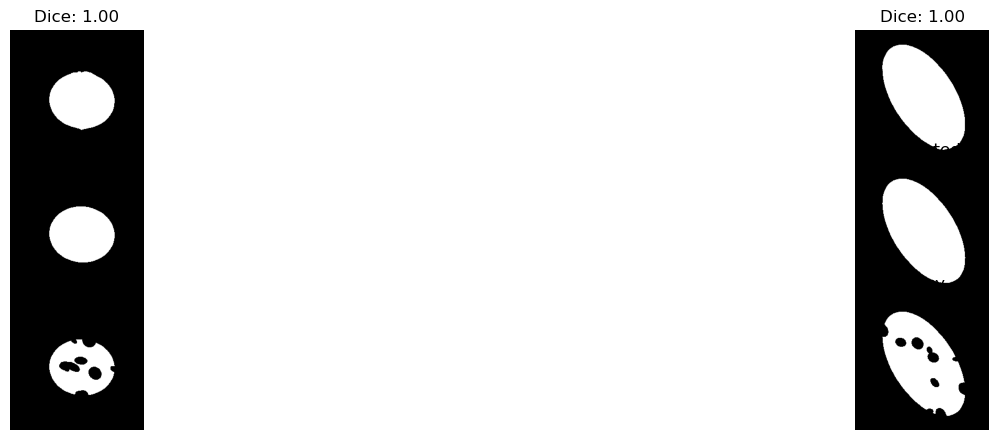

Mean dice: 0.9970928322735705
End of batch 3
Final Mean dice: 0.9971185144069855


In [36]:
import glob
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image

model_name_dict = "./model/epoch_15.pth" # our current best model
noisy_data_path = "./data/noisy" # path to noisy images
data_path = "./data/full" # path to full images

def load_data(noisy_path, data_path):
    noisy_imgs = glob.glob(noisy_path + "/*.*")
    data_imgs = glob.glob(data_path + "/*.*")
    noisy_imgs.sort()
    data_imgs.sort()
    print(noisy_imgs)
    print(data_imgs)
    
    try:
        assert len(noisy_imgs) == len(data_imgs)
    except AssertionError:
        print("Different number of images in noisy and data folders")
        return None
    
    try:
        noisy_imgs = [Image.open(img).convert("L") for img in noisy_imgs]
        data_imgs = [Image.open(img).convert("L") for img in data_imgs]

        transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor()
        ])
        noisy_imgs = [transform(img) for img in noisy_imgs]
        data_imgs = [transform(img) for img in data_imgs]
    except Exception as e:
        print(e)
        return None



    return noisy_imgs, data_imgs

noisy_data, data = load_data(noisy_data_path, data_path)
# just 16
def load_and_predict(model_name, noisy_data, data):
    model = ResidualAutoencoder().to(device)
    model.load_state_dict(torch.load(model_name))
    noisy_data = torch.stack(noisy_data).to(device)
    data = torch.stack(data).to(device)
    print(f"Tensor Shape: {noisy_data.shape}")
    dices = list()
    for i in range(0, len(noisy_data), 16):
        print("="*40)
        print(f"Batch {i // 16}")
        noisy_data_batch = noisy_data[i:i+16]
        data_batch = data[i:i+16]
        dice = plot_and_dice(model, noisy_data_batch, data_batch)
        dices.append(dice)
        print(f"End of batch {i // 16}")
        print("="*40)
    print(f"Final Mean dice: {np.mean(dices)}")
    
load_and_predict(model_name_dict, noisy_data, data)
    